In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Pre-processamento: Home Credit Default Risk

 O conjunto de dados Home Credit Default Risk, originado de uma competição no Kaggle, encapsula um problema de negócios do mundo real: como estender serviços financeiros a populações "não bancarizadas" ou com histórico de crédito limitado, mantendo ao mesmo tempo um modelo de empréstimo responsável. A tarefa central é prever a probabilidade de um solicitante de empréstimo inadimplir, um componente essencial conhecido como Probabilidade de Inadimplência (PD) na modelagem de risco de crédito. A solução para este problema reside na utilização de "dados alternativos", que vão além das pontuações de crédito tradicionais, para formar uma visão holística da capacidade de pagamento de um cliente.   

O conjunto de dados não é uma tabela única, mas um ecossistema de múltiplos arquivos interligados. O arquivo central, application_{train|test}.csv, contém dados estáticos para cada empréstimo, identificado por um SK_ID_CURR único, e serve como a âncora para a análise.


In [2]:
app_train = pd.read_csv('../../data/home-credit/application_train.csv', low_memory=True)
app_test = pd.read_csv('../../data/home-credit/application_test.csv', low_memory=True)
bureau = pd.read_csv('../../data/home-credit/bureau.csv', low_memory=True)
bureau_balance = pd.read_csv('../../data/home-credit/bureau_balance.csv', low_memory=True)
previous_application = pd.read_csv('../../data/home-credit/previous_application.csv', low_memory=True)
pos_cash_balance = pd.read_csv('../../data/home-credit/POS_CASH_balance.csv', low_memory=True)
credit_card_balance = pd.read_csv('../../data/home-credit/credit_card_balance.csv', low_memory=True)
installments_payments = pd.read_csv('../../data/home-credit/installments_payments.csv', low_memory=True)

## 1. Pré-processamento dos Dados da tabela **application**

In [7]:


print(f"Dimensões de app_train: {app_train.shape}")
print(f"Dimensões de app_test: {app_test.shape}")

print("\nCabeçalho de app_train:")
display(app_train.head())

print("\nInformações sobre app_train:")
app_train.info()

Dimensões de app_train: (307511, 244)
Dimensões de app_test: (48744, 240)

Cabeçalho de app_train:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZA


Informações sobre app_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 244 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: bool(135), float64(66), int64(43)
memory usage: 295.3 MB


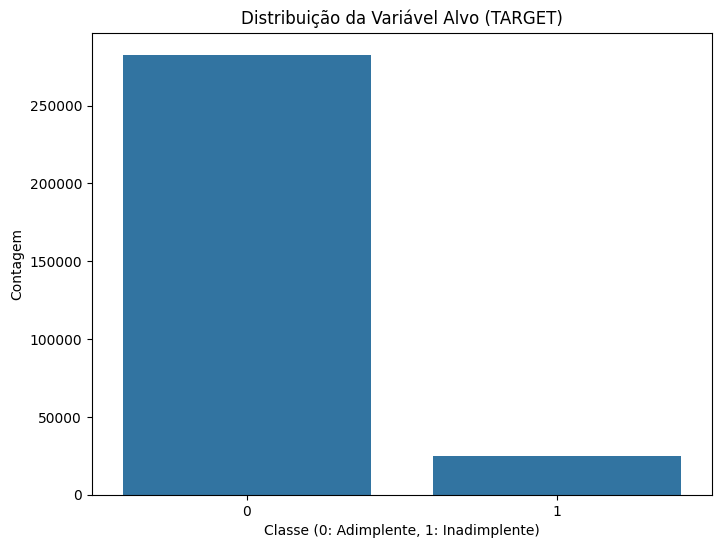

In [8]:

plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=app_train)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('Classe (0: Adimplente, 1: Inadimplente)')
plt.ylabel('Contagem')
plt.show()

In [5]:
# Identificando uma anomalia em DAYS_EMPLOYED
print(f"Número de ocorrências do valor anômalo em DAYS_EMPLOYED: {(app_train['DAYS_EMPLOYED'] == 365243).sum()}")

# Criando uma nova coluna binária para marcar as anomalias
# Esta nova característica pode ser preditiva por si só
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243

# Substituindo o valor anômalo por NaN (Not a Number) para que possa ser tratado como um valor ausente
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Verificando outras colunas de 'DAYS' para consistência.
# Os valores são negativos, representando dias antes da data da solicitação.
# Convertendo para positivo para facilitar a interpretação.
days_cols = [col for col in app_train.columns if 'DAYS' in col]
for col in days_cols:
    app_train[col] = abs(app_train[col])
    app_test[col] = abs(app_test[col])

Número de ocorrências do valor anômalo em DAYS_EMPLOYED: 0


In [6]:
# Criando uma instância do LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterando sobre as colunas para aplicar Label Encoding em variáveis binárias
for col in app_train:
    if app_train[col].dtype == 'object':
        # Se a coluna tiver 2 ou menos categorias únicas
        if len(list(app_train[col].unique())) <= 2:
            # Treina o encoder nos dados de treino
            le.fit(app_train[col])
            # Transforma os dados de treino e teste
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
print(f'{le_count} colunas foram codificadas com Label Encoding.')

# Aplicando One-Hot Encoding nas variáveis categóricas restantes
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print(f"Dimensões de app_train após OHE: {app_train.shape}")
print(f"Dimensões de app_test após OHE: {app_test.shape}")

# Alinhando os dataframes de treino e teste
# Isso garante que ambos tenham as mesmas colunas após o OHE
train_labels = app_train
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# Adicionando a coluna TARGET de volta ao dataframe de treino
app_train = train_labels

print(f"Dimensões de app_train após alinhamento: {app_train.shape}")
print(f"Dimensões de app_test após alinhamento: {app_test.shape}")

3 colunas foram codificadas com Label Encoding.
Dimensões de app_train após OHE: (307511, 244)
Dimensões de app_test após OHE: (48744, 240)
Dimensões de app_train após alinhamento: (307511, 244)
Dimensões de app_test após alinhamento: (48744, 240)


In [8]:
# Função para calcular a porcentagem de valores ausentes por coluna
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Valores Ausentes', 1: '% do Total'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1]!= 0].sort_values(
        '% do Total', ascending=False).round(1)
    print(f"O dataframe tem {df.shape} colunas.\n"
          f"Há {mis_val_table_ren_columns.shape} colunas com valores ausentes.")
    return mis_val_table_ren_columns

# Gerando a tabela de valores ausentes para os dados de aplicação
missing_values = missing_values_table(app_train)
print("\nTop 20 colunas com maior porcentagem de valores ausentes:")
display(missing_values.head(20))

O dataframe tem (307511, 244) colunas.
Há (62, 2) colunas com valores ausentes.

Top 20 colunas com maior porcentagem de valores ausentes:


,Valores Ausentes,% do Total
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
FLOORSMIN_MODE,208642,67.8


In [9]:
# Criando uma instância do imputer com a estratégia da mediana
imputer = SimpleImputer(strategy='median')

# Selecionando apenas as colunas numéricas
numeric_cols = app_train.select_dtypes(include=np.number).columns.drop('TARGET')
train_ids = app_train
test_ids = app_test

# Ajustando o imputer APENAS nos dados de treino para evitar vazamento de dados
imputer.fit(app_train[numeric_cols])

# Transformando os dados de treino e teste
app_train[numeric_cols] = imputer.transform(app_train[numeric_cols])
app_test[numeric_cols] = imputer.transform(app_test[numeric_cols])

# Restaurando os IDs
app_train = train_ids
app_test = test_ids

print("Valores ausentes imputados com sucesso.")

Valores ausentes imputados com sucesso.


### Engenharia de Atributos a Partir de Conjuntos de Dados Auxiliares

In [10]:
app_train["CREDIT_INCOME_PERCENT"] = app_train["AMT_CREDIT"] / app_train["AMT_INCOME_TOTAL"]
app_train["ANNUITY_INCOME_PERCENT"] = app_train["AMT_ANNUITY"] / app_train["AMT_INCOME_TOTAL"]
app_train["CREDIT_TERM"] = app_train["AMT_ANNUITY"] / app_train["AMT_CREDIT"]
app_train["DAYS_EMPLOYED_PERCENT"] = app_train["DAYS_EMPLOYED"] / app_train["DAYS_BIRTH"]

app_test["CREDIT_INCOME_PERCENT"] = app_test["AMT_CREDIT"] / app_test["AMT_INCOME_TOTAL"]
app_test["ANNUITY_INCOME_PERCENT"] = app_test["AMT_ANNUITY"] / app_test["AMT_INCOME_TOTAL"]
app_test["CREDIT_TERM"] = app_test["AMT_ANNUITY"] / app_test["AMT_CREDIT"]
app_test["DAYS_EMPLOYED_PERCENT"] = app_test["DAYS_EMPLOYED"] / app_test["DAYS_BIRTH"]

## 2.  Integrando o Histórico do Bureau de Crédito (bureau.csv & bureau_balance.csv)

In [11]:
# Pré-processamento de bureau_balance.csv
# One-hot encode da coluna STATUS
bureau_balance_ohe = pd.get_dummies(bureau_balance, columns=['STATUS'])

# Agrupando por SK_ID_BUREAU
bureau_balance_agg = bureau_balance_ohe.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'size'], # Duração e recência do histórico
    **{col: ['mean'] for col in bureau_balance_ohe.columns if 'STATUS_' in col} # Proporção de cada status
})

# Renomeando as colunas para evitar nomes multinível
bureau_balance_agg.columns = pd.Index(['_'.join(e) for e in bureau_balance_agg.columns.tolist()])

In [ ]:
# Juntando bureau com bureau_balance agregado
bureau_full = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')

# Não há colunas a serem removidas explicitamente aqui, então esta linha é removida ou ajuste conforme necessário
# bureau_full.drop(columns=[...], inplace=True)

# Agregações numéricas
numeric_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# Agregações categóricas
bureau_ohe = pd.get_dummies(bureau_full)
categorical_aggregations = {col: ['mean'] for col in bureau_ohe.columns if col not in bureau.columns and bureau_ohe[col].dtype in [np.uint8, np.int64, np.float64, bool]}

# Agrupando por SK_ID_CURR
bureau_agg = bureau_ohe.groupby('SK_ID_CURR').agg({**numeric_aggregations, **categorical_aggregations})

# Renomeando colunas
bureau_agg.columns = ['_'.join(col).upper() for col in bureau_agg.columns]

# Se quiser contar empréstimos ativos e fechados, pode-se fazer algo assim:
# Exemplo: contar número de empréstimos ativos
if 'CREDIT_ACTIVE_Active' in bureau_ohe.columns:
    active_loans = bureau_ohe[bureau_ohe['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').size()
    bureau_agg['ACTIVE_LOANS_COUNT'] = active_loans
    bureau_agg['ACTIVE_LOANS_COUNT'].fillna(0, inplace=True)